In [33]:
import numpy as np
import scipy.linalg as la
import networkx as nx
import time
import pdb
n = 5 # num nodes
m = 5  # input dimension
p = 5 # output dimension
T = 15  # control horizon
N = 1000  # samples
sigma = 1
yf = np.random.randn(p, 1)*sigma  # target state

# consider Barabasi–Albert networks with average degree 〈k〉 = n*(n*log(n)+0.1)
if int(np.log(n)) == 0:
    num_of_connections = 1
else:
    num_of_connections = int(np.log(n))
G = nx.barabasi_albert_graph(n, num_of_connections)
A = nx.adjacency_matrix(G).astype(float).todense()
print(A.sum()/A.shape[0])
adj = np.copy(A)
A /= np.sqrt(n)

## input matrix
B = np.zeros((n, m))
# randomly set the driver node of each input signal
b = np.random.permutation(n)[:m] 
B[b, np.arange(m)] = 1

# output matrix
C = np.zeros((p, n))

c = np.random.permutation(n)[:p]
C[np.arange(p), c] = 1
# C =np.identity(n)

# state space system
sys_A = A
sys_B = B
sys_C = C

# compute T-steps system Hankel matrix
C_mat = np.dot(sys_C, sys_B)
for i in range(T):
    C_mat = np.concatenate((C_mat, np.dot(sys_C, np.linalg.matrix_power(sys_A, i+1)).dot(sys_B)), axis=-1)
print(C_mat.shape)
u,s,v = np.linalg.svd(C_mat)
if s.min()<1e-5:
    raise ValueError
H = np.zeros((p * T, m * T))
for r in range(1, T+1):
    for k in range(1, T+1):
        if k > T - r:
            H[(r-1)*p:r*p, (k-1)*m:k*m] = np.dot(sys_C, np.linalg.matrix_power(sys_A, r-T+k-1)).dot(sys_B)

U = np.random.randn(m * T, N)*sigma
U_3d = np.reshape(U, (T, m, N)).transpose(2, 0, 1)
Y = np.dot(H, U)
Y_bar = Y[:(T - 1) * p, :]
Y_bar_3d = np.reshape(Y_bar, ((T - 1), p, N)).transpose(2, 0, 1)
Y_f = Y[(T - 1) * p:, :]
Y_f_3d = Y_f.transpose(1, 0)
# output shape
print(U_3d.shape)
print(Y_bar_3d.shape, Y_f_3d.shape)

1.6
(5, 80)
(1000, 15, 5)
(1000, 14, 5) (1000, 5)


In [57]:
v = np.random.randn(2*3,4)
v_3 = np.reshape(v,(2,3,4))
print(v,'\n\n', v_3[0],'\n\n', v_3[1])

[[-0.19934619 -0.59540087 -0.68147273  1.4824974 ]
 [ 1.21898395  0.22696198 -0.44243652 -0.4946283 ]
 [-1.15691951 -0.702543   -0.01366045  0.11321394]
 [ 1.55041965  0.54778604 -1.0979772  -0.24924443]
 [ 2.14510913 -0.08359201  0.40781867 -1.72221584]
 [-0.11537637 -1.12302149 -0.23747056 -1.07523649]] 

 [[-0.19934619 -0.59540087 -0.68147273  1.4824974 ]
 [ 1.21898395  0.22696198 -0.44243652 -0.4946283 ]
 [-1.15691951 -0.702543   -0.01366045  0.11321394]] 

 [[ 1.55041965  0.54778604 -1.0979772  -0.24924443]
 [ 2.14510913 -0.08359201  0.40781867 -1.72221584]
 [-0.11537637 -1.12302149 -0.23747056 -1.07523649]]


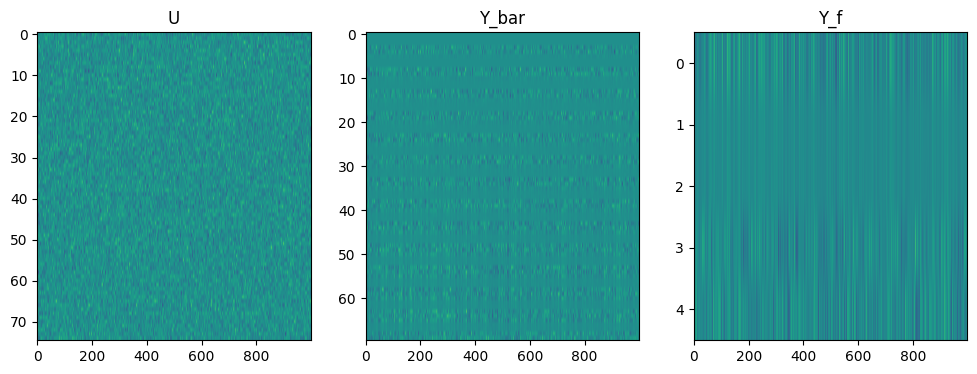

In [27]:
import matplotlib.pyplot as plt

def visualize(U, Y_bar, Y_f):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(U, aspect='auto')
    ax[0].set_title('U')
    ax[1].imshow(Y_bar, aspect='auto')
    ax[1].set_title('Y_bar')
    ax[2].imshow(Y_f, aspect='auto')
    ax[2].set_title('Y_f')
    plt.show()

def draw_distribution(U, Y_bar, Y_f):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].hist(U.flatten(), bins=100)
    ax[0].set_title('U')
    ax[1].hist(Y_bar.flatten(), bins=100)
    ax[1].set_title('Y_bar')
    ax[2].hist(Y_f.flatten(), bins=100)
    ax[2].set_title('Y_f')
    plt.show()
visualize(U, Y_bar, Y_f)

In [34]:
# save as .pkl
import pickle
data_name = f'scale_free_{n}_{m}_{p}_{T}_{N}_sigma_{sigma}.pkl'
data_dict = {}
data_dict['sys'] = {'A': sys_A, 'B': sys_B, 'C': sys_C}
data_dict['adj'] = adj
data_dict['meta_data'] = {'num_nodes': n, 'input_dim': m, 'output_dim': p, 'control_horizon': T, 'num_samples': N, 'num_edges': adj.sum()}
data_dict['data'] = {'U': U_3d, 'Y_bar': Y_bar_3d, 'Y_f': Y_f_3d}
with open('/home/joe/projects/GraphDiffuser/data/synthetic_data/'+data_name, 'wb') as f:
    pickle.dump(data_dict, f)

In [66]:
import torch

# 假设你有一个形状为[T, M]的Tensor
T = 5
M = 4
x = torch.randn(T, M)

# 使用view方法将其转换为一个[T*M]的向量
y = x.view(-1)

# 或者，你也可以使用reshape方法
z = y.view(5,-1)

# 现在，y和z都是形状为[T*M]的向量
print(x)
print(y)
print(z)

tensor([[ 2.3577, -0.0636, -0.5353,  0.6885],
        [ 0.6314, -0.5049,  1.5543, -0.1861],
        [ 0.4992, -0.3927, -0.7925, -0.0224],
        [-0.6120, -0.1312, -1.0185,  1.0709],
        [-0.4447,  1.0864, -1.3351, -0.2666]])
tensor([ 2.3577, -0.0636, -0.5353,  0.6885,  0.6314, -0.5049,  1.5543, -0.1861,
         0.4992, -0.3927, -0.7925, -0.0224, -0.6120, -0.1312, -1.0185,  1.0709,
        -0.4447,  1.0864, -1.3351, -0.2666])
tensor([[ 2.3577, -0.0636, -0.5353,  0.6885],
        [ 0.6314, -0.5049,  1.5543, -0.1861],
        [ 0.4992, -0.3927, -0.7925, -0.0224],
        [-0.6120, -0.1312, -1.0185,  1.0709],
        [-0.4447,  1.0864, -1.3351, -0.2666]])


In [33]:
import pickle
import numpy as np
data_name='erdos_renyi_30_5_30_15_1000.pkl'
with open('/home/joe/projects/GraphDiffuser/data/synthetic_data/'+data_name, 'rb') as f:
    data = pickle.load(f)
sys_A = data['sys']['A']
sys_B = data['sys']['B']
sys_C = data['sys']['C']
T = data['meta_data']['control_horizon']
C_mat = np.dot(sys_C, sys_B)
for i in range(T):
    C_mat = np.concatenate((C_mat, np.dot(sys_C, np.linalg.matrix_power(sys_A, i+1)).dot(sys_B)), axis=-1)
print(C_mat.shape)
u,s,v = np.linalg.svd(C_mat)
print(s.min(), s.max(), len(s))

(30, 80)
0.00019576745864660224 2.7795042774885386 30


In [20]:
import networkx as nx
import pickle
import numpy as np
data_name='erdos_renyi_20_5_5_15_1000.pkl'
with open('/home/joe/projects/GraphDiffuser/data/synthetic_data/'+data_name, 'rb') as f:
    data = pickle.load(f)
n = data['meta_data']['num_nodes']
m = data['meta_data']['input_dim']
p = data['meta_data']['output_dim']
T = data['meta_data']['control_horizon']
N = data['meta_data']['num_samples']
sigma = 10
yf = np.random.randn(p, 1)*sigma  # target state

# adjacency matrix E-R graph



adj = data['adj']
A = data['sys']['A']

## input matrix
B = data['sys']['B']

# output matrix
C = data['sys']['C']

sys_A = A
sys_B = B
sys_C = C

# compute T-steps system Hankel matrix
C_mat = np.dot(sys_C, sys_B)
for i in range(T):
    C_mat = np.concatenate((C_mat, np.dot(sys_C, np.linalg.matrix_power(sys_A, i+1)).dot(sys_B)), axis=-1)
print(C_mat.shape)
u,s,v = np.linalg.svd(C_mat)
if s.min()<1e-5:
    raise ValueError
H = np.zeros((p * T, m * T))
for r in range(1, T+1):
    for k in range(1, T+1):
        if k > T - r:
            H[(r-1)*p:r*p, (k-1)*m:k*m] = np.dot(sys_C, np.linalg.matrix_power(sys_A, r-T+k-1)).dot(sys_B)

U = np.random.randn(m * T, N)*sigma
U_3d = np.reshape(U, (T, m, N)).transpose(2, 0, 1)
Y = np.dot(H, U)
Y_bar = Y[:(T - 1) * p, :]
Y_bar_3d = np.reshape(Y_bar, ((T - 1), p, N)).transpose(2, 0, 1)
Y_f = Y[(T - 1) * p:, :]
Y_f_3d = Y_f.transpose(1, 0)
# output shape
print(U_3d.shape)
print(Y_bar_3d.shape, Y_f_3d.shape)
# save as .pkl
# import pickle
data_name = f'erdos_renyi_{n}_{m}_{p}_{T}_{N}_sigma_{sigma}.pkl'
data_dict = {}
data_dict['sys'] = {'A': sys_A, 'B': sys_B, 'C': sys_C}
data_dict['adj'] = adj
data_dict['meta_data'] = {'num_nodes': n, 'input_dim': m, 'output_dim': p, 'control_horizon': T, 'num_samples': N, 'num_edges': adj.sum()}
data_dict['data'] = {'U': U_3d, 'Y_bar': Y_bar_3d, 'Y_f': Y_f_3d}
with open('/home/joe/projects/GraphDiffuser/data/synthetic_data/'+data_name, 'wb') as f:
    pickle.dump(data_dict, f)

(5, 80)
(1000, 15, 5)
(1000, 14, 5) (1000, 5)
